In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
    raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


/home/twist/tensorflow/venv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/twist/tensorflow/venv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/twist/tensorflow/venv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%matplotlib inline

In [5]:
from utils import label_map_util

from utils import visualization_utils as vis_util

In [6]:
PATH_TO_CKPT = 'output/frozen_inference_graph.pb'

In [7]:
PATH_TO_LABELS = 'data/object-detection.pbtxt'

In [8]:
NUM_CLASSES = 1

In [9]:
# load graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [10]:
# load labels
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [11]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [12]:
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = []
for f in os.listdir(PATH_TO_TEST_IMAGES_DIR):
    TEST_IMAGE_PATHS.append(os.path.join(PATH_TO_TEST_IMAGES_DIR, f))
#TEST_IMAGE_PATHS = ["test_images/frame779.jpg"]
print(TEST_IMAGE_PATHS)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

['test_images/00_032_021.jpg', 'test_images/00_032_016.jpg', 'test_images/00_032_012.jpg', 'test_images/00_032_024.jpg', 'test_images/00_032_018.jpg', 'test_images/00_032_005.jpg', 'test_images/00_032_023.jpg', 'test_images/00_032_020.jpg', 'test_images/00_032_004.jpg', 'test_images/00_032_013.jpg', 'test_images/00_032_007.jpg', 'test_images/00_032_006.jpg', 'test_images/00_032_001.jpg', 'test_images/00_032_014.jpg', 'test_images/00_032_008.jpg', 'test_images/00_032_019.jpg', 'test_images/00_032_011.jpg', 'test_images/00_032_022.jpg', 'test_images/00_032_003.jpg', 'test_images/00_032_025.jpg', 'test_images/00_032_010.jpg', 'test_images/00_032_002.jpg', 'test_images/00_032_015.jpg', 'test_images/00_032_009.jpg', 'test_images/00_032_000.jpg', 'test_images/00_032_026.jpg', 'test_images/00_032_017.jpg', 'test_images/00_032_027.jpg']


In [13]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [33]:
#returns tuple (n_arr, score)= numpy array cropped head and classification score
def cut_head(image_path):
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    im_width, im_height = image.size
    detection_boxes = output_dict['detection_boxes']
    detection_classes = output_dict['detection_classes']
    detection_scores = output_dict['detection_scores']
    score = detection_scores[0]
    print("highest score = {}".format(detection_scores[0]))
    box = detection_boxes[0]
    ymin, xmin, ymax, xmax = box
    (left, right, top, bottom) = (int(xmin * im_width), int(xmax * im_width),
                                  int(ymin * im_height), int(ymax * im_height))
    
    area = (left, top, right, bottom)
    print("area = {}".format(area))
    # Visualization of the results of a detection.
#     print(output_dict['detection_classes'])
#     print(output_dict['detection_boxes'])
#     print('s============s')
#     print('s============s')
#     print('s============s')
#     print('s============s')
#     print(output_dict['detection_scores'])
#     draw = ImageDraw.Draw(image)
#     draw.line([(left, top), (left, bottom), (right, bottom),
#              (right, top), (left, top)], width=4, fill='red')
#     print(type(image))
    cropped = image.crop(area)
    n_arr = np.array(cropped)
#     print(n)
#     w1, h1 = image.size
#     w2, h2 = cropped.size
#     print(type(cropped))
#     print(image.size)
#     print(cropped.size)
#     n = np.asarray(cropped)
#     cropped.show()
#     print(n)
#     print(cropped)
#     cropped.save('test1.jpg')
#     from IPython.display import display
    
#     plt.figure(figsize=IMAGE_SIZE)
#     plt.imshow(cropped)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.imshow(image)
    
    return (n_arr, score)

In [26]:
!mkdir test_images_heads

highest score = 0.5685834288597107
area = (86, 69, 181, 151)
box
(0.28845077753067017, 0.26918545365333557, 0.6301652789115906, 0.5682802200317383)
highest score = 0.41811609268188477
area = (118, 114, 175, 173)
highest score = 0.5390793681144714
area = (96, 115, 192, 194)
box
(0.4795476794242859, 0.3001236915588379, 0.8084505200386047, 0.6017562747001648)
highest score = 0.26617470383644104
area = (6, 24, 101, 100)
highest score = 0.7196131944656372
area = (106, 98, 191, 174)
box
(0.4123465418815613, 0.3341166377067566, 0.725402295589447, 0.5985341668128967)
highest score = 0.571259617805481
area = (196, 61, 260, 123)
box
(0.25608205795288086, 0.6154019832611084, 0.5160098075866699, 0.8152981996536255)
highest score = 0.29116761684417725
area = (31, 25, 86, 82)
highest score = 0.694898247718811
area = (102, 80, 193, 162)
box
(0.3374224901199341, 0.3192307651042938, 0.6764285564422607, 0.6055716276168823)
highest score = 0.4518851637840271
area = (233, 48, 291, 109)
highest score = 0.5

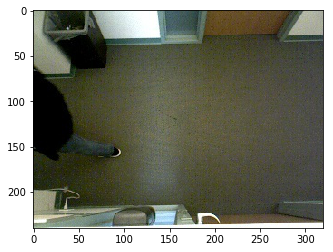

In [34]:
for image_path in TEST_IMAGE_PATHS:
    img_n_arr, score = cut_head(image_path)
#     plt.imshow(img_n_arr)
    fname = image_path.split("/")[1]
    fout = os.path.join("test_images_heads", fname)
    Image.fromarray(img_n_arr).save(fout)